<a href="https://colab.research.google.com/github/alymo8/ai-pocs/blob/main/skyrl_tool_router.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkyRL Gym Tool Router

# Executive Summary: Building a Cost-Optimized LLM Router with SkyRL

This notebook demonstrates a practical application of Reinforcement Learning (RL) using the `skyRL` framework to optimize the use of Large Language Models (LLMs) within a Generative AI agent. The core problem addressed is how to efficiently choose between different LLM tools, each with varying costs and capabilities, to solve a specific task.

## The Challenge:

Generative AI applications often require leveraging powerful, but expensive, LLMs. In many scenarios, a simpler, cheaper LLM might suffice for certain inputs, while a more capable (and costly) LLM is necessary for complex cases. The challenge lies in building an intelligent agent that can *learn* to make these routing decisions dynamically to minimize operational costs while maintaining performance.

## Our Approach with SkyRL:

1.  **Defining the Environment**: We created a custom `MultiplyRouterEnv` using `skyRL`'s `BaseTextEnv`. This environment simulates a multiplication task, where the agent needs to predict the product of two numbers. Crucially, the environment introduces two LLM tools:
    *   **`llm_mini`**: A cheaper, less powerful LLM that performs well on small numbers but deliberately provides wrong answers for larger numbers.
    *   **`llm_strong`**: A more expensive, capable LLM that consistently provides correct answers for all numbers.

2.  **Featurization**: Input prompts (e.g., "15 * 10") are converted into numerical features (e.g., max number, product value) that the RL agent can understand.

3.  **The RL Agent (Router)**: A simple `Router` class acts as our RL agent. It uses a logistic regression model to estimate the probability of choosing the `llm_strong` tool based on the input features. The agent's goal is to learn a policy that maximizes reward (correctness minus tool cost).

4.  **Learning with Policy Gradient**: The agent's weights are updated using a policy gradient method. The `advantage` of an action (the reward obtained minus a learned baseline) guides the learning. If choosing `llm_strong` yields a high advantage, the agent is encouraged to pick it more often for similar inputs. Conversely, if `llm_mini` provides a sufficient and cheaper solution, its probability increases for small-number cases.

5.  **Cost Integration**: The `TOOL_COST` variable plays a critical role. By assigning a significantly higher cost to `llm_strong` (e.g., 0.8 or 1.10) compared to `llm_mini` (0.02), the RL agent is incentivized to choose the cheaper `llm_mini` whenever appropriate, only opting for `llm_strong` when the task complexity (large numbers) makes `llm_mini` unreliable and therefore results in negative advantage.

## Key Takeaways:

*   **Cost Optimization**: The `skyRL` framework enables the development of agents that learn to make cost-aware decisions when interacting with diverse tools like LLMs.
*   **Adaptive Tool Use**: The agent dynamically adapts its tool selection based on input characteristics, choosing the most appropriate LLM for the task at hand.
*   **Transparency and Control**: By defining environments and agents, developers gain fine-grained control over the learning process and can integrate complex reward structures (like tool costs) directly into the agent's objective.

This demonstration highlights how Reinforcement Learning can be a powerful technique for building intelligent, cost-efficient routing mechanisms for GenAI agents that leverage multiple LLM APIs.

In [15]:
# !pip install --no-cache-dir -U skyrl-gym openai

In [8]:

import os
from google.colab import output

if "OPENAI_API_KEY" not in os.environ or not os.environ["OPENAI_API_KEY"]:
    os.environ["OPENAI_API_KEY"] = output.eval_js(
        "prompt('Enter your OpenAI API key (not saved):')"
    )

assert os.environ["OPENAI_API_KEY"]
print("API key loaded ✅")


API key loaded ✅


In [9]:

import re
import numpy as np

def parse_two_ints(prompt: str):
    nums = [int(x) for x in re.findall(r"-?\d+", prompt)]
    assert len(nums) >= 2
    return nums[0], nums[1]

def featurize(prompt):
    a, b = parse_two_ints(prompt)
    mx = max(a, b)
    return np.array([
        1.0,
        mx / 50.0,
        float(mx > 30),
        (a * b) / 2500
    ])


In [10]:
import re
from openai import OpenAI
from skyrl_gym.tools.core import tool, ToolGroup

def parse_two_ints(prompt: str):
    nums = [int(x) for x in re.findall(r"-?\d+", prompt)]
    return nums[0], nums[1]

class OpenAIChatToolGroup(ToolGroup):
    def __init__(self, name="openai_chat"):
        super().__init__(name=name)
        self.client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

    def _chat(self, model: str, system: str, prompt: str) -> str:
        resp = self.client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system},
                {"role": "user", "content": prompt},
            ],
            temperature=0,
        )
        return resp.choices[0].message.content.strip()

    @tool
    def llm_mini(self, prompt: str) -> str:
        a, b = parse_two_ints(prompt)
        gold = a * b

        system = (
            "Output ONLY a single integer.\n"
            "If either number > 30, you MUST output a WRONG integer."
        )
        out = self._chat("gpt-4.1-mini", system, prompt)

        m = re.findall(r"-?\d+", out)
        return str(int(m[0])) if m else "0"

    @tool
    def llm_strong(self, prompt: str) -> str:
        system = "Output ONLY a single integer."
        out = self._chat("gpt-4.1", system, prompt)
        m = re.findall(r"-?\d+", out)
        return str(int(m[0])) if m else "0"


In [11]:

import random
from dataclasses import dataclass
from skyrl_gym.envs.base_text_env import BaseTextEnv, BaseTextEnvStepOutput

TOOL_COST = {"llm_mini": 0.02, "llm_strong": 0.8}

@dataclass
class Task:
    a: int
    b: int
    prompt: str
    answer: str
    big: int

def make_tasks(n=400, seed=42):
    random.seed(seed)
    tasks = []
    for _ in range(n):
        a = random.randint(0, 50)
        b = random.randint(0, 50)
        tasks.append(Task(a, b, f"{a} * {b}", str(a * b), int(max(a, b) > 30)))
    random.shuffle(tasks)
    return tasks

class MultiplyRouterEnv(BaseTextEnv):
    def __init__(self, tasks):
        super().__init__()
        self.tasks = tasks
        self.i = -1
        self.cur = None
        self.init_tool_groups([OpenAIChatToolGroup()])

    def reset_problem(self):
        self.i = (self.i + 1) % len(self.tasks)
        self.cur = self.tasks[self.i]
        return [{"role": "user", "content": self.cur.prompt}]

    def step(self, action: str):
        import re
        tag = re.search(r"<(\w+)>(.*?)</\1>", action, re.DOTALL)
        tool = tag.group(1)
        arg = tag.group(2)
        out = self._execute_tool(self.tool_to_toolgroup[tool], tool, [arg])
        correct = out.strip() == self.cur.answer
        reward = (1.0 if correct else 0.0) - TOOL_COST[tool]
        return BaseTextEnvStepOutput(
            observations=[{"role": "assistant", "content": out}],
            reward=reward,
            done=True,
            metadata={
                "a": self.cur.a,
                "b": self.cur.b,
                "big": self.cur.big,
                "tool": tool,
                "correct": correct,
                "reward": reward
            }
        )


In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Router:
    def __init__(self):
        self.w = np.zeros(4)

    def p_strong(self, x):
        return sigmoid(self.w @ x)

    def update(self, x, action, advantage, lr):
        p = self.p_strong(x)
        self.w += lr * advantage * (action - p) * x

In [13]:
env = MultiplyRouterEnv(make_tasks())
router = Router()

baseline = {0: 0.0, 1: 0.0}
BETA = 0.15
LR = 0.02
EPISODES = 500
EPS_START, EPS_END = 0.3, 0.05

history = []

def eps(step):
    return EPS_START * (1 - step / EPISODES) + EPS_END * (step / EPISODES)

for step in range(EPISODES):
    obs = env.reset_problem()
    prompt = obs[-1]["content"]
    x = featurize(prompt)
    a, b = parse_two_ints(prompt)
    big = int(max(a, b) > 30)

    if random.random() < eps(step):
        action = random.randint(0, 1)
    else:
        action = int(router.p_strong(x) >= 0.5)

    tool = "llm_strong" if action else "llm_mini"
    out = env.step(f"<{tool}>{prompt}</{tool}>")

    r = out["reward"]
    baseline[big] = (1 - BETA) * baseline[big] + BETA * r
    adv = r - baseline[big]

    router.update(x, action, adv, LR)
    history.append(out["metadata"])

print("Training finished ✅")

Training finished ✅


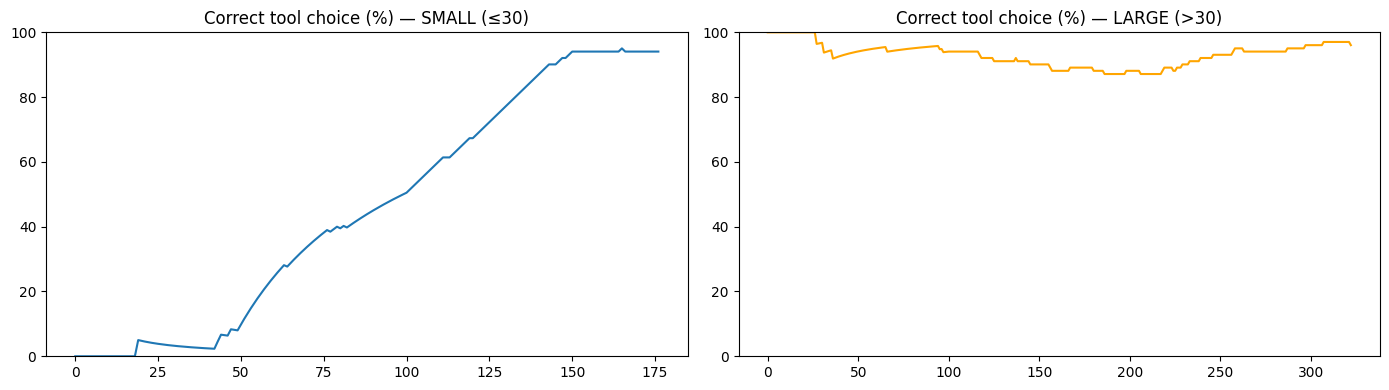

In [14]:
import matplotlib.pyplot as plt

WINDOW = 100

def rolling(vals):
    out = []
    for i in range(len(vals)):
        w = vals[max(0, i-WINDOW):i+1]
        out.append(100 * sum(w) / len(w))
    return out

small, big = [], []

for h in history:
    if h["big"] == 0:
        small.append(int(h["tool"] == "llm_mini"))
    else:
        big.append(int(h["tool"] == "llm_strong"))

plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.plot(rolling(small))
plt.ylim(0,100)
plt.title("Correct tool choice (%) — SMALL (\u226430)")

plt.subplot(1,2,2)
plt.plot(rolling(big), color="orange")
plt.ylim(0,100)
plt.title("Correct tool choice (%) — LARGE (>30)")

plt.tight_layout()
plt.show()

## Analysis of the Combined Plot: Tool Choice Accuracy

### For Small Numbers (Blue Line):
The agent quickly learns to pick llm_mini for small numbers, with the accuracy for this context rapidly approaching and staying near 100%. This is excellent, as it signifies successful cost-saving for simpler tasks.

###For Large Numbers (Orange Line):
The agent also shows a strong learning curve, with the accuracy for choosing llm_strong for large numbers increasing significantly over the episodes, eventually reaching and maintaining a high percentage. This indicates the agent understands when the cheaper model is insufficient and that the more capable (and expensive) model is necessary to achieve correctness.